In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import random_split
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
from thermostability.thermo_dataset import ThermostabilityDataset
from util.telegram import TelegramBot
from tqdm.notebook import tqdm
import sys
from util.train import train_model
from torch import nn
from uni_prot.dense_model import DenseModel

cudnn.benchmark = True

if torch.cuda.is_available():
    torch.cuda.empty_cache() 
    
cpu = torch.device("cpu")

torch.cuda.list_gpu_processes()
telegramBot = TelegramBot()



/hpi/fs00/home/hoangan.nguyen/anaconda3/envs/hotshot/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'GPU:0\nno processes are running'

In [2]:
from uni_prot.uni_prot_dataset import UniProtDataset
train_ds = UniProtDataset("train.csv")
val_ds = UniProtDataset("val.csv")

In [3]:
import torch
from torch.utils.data import DataLoader
dataloaders = {
    "train": DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2),
    "val": DataLoader(val_ds, batch_size=2, shuffle=True, num_workers=2)
}

dataset_sizes = {"train": len(train_ds),"val": len(val_ds)}
print(dataset_sizes)

{'train': 19374, 'val': 1920}


In [4]:

model = DenseModel()
model.to("cuda:0")

criterion = nn.MSELoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/4
----------
train Loss: 50.8525: [9687/9687], loss: 39.679466, batch abs diff mean 6.21632097
val Loss: 31.6622ch: [960/960], loss: 10.408332, batch abs diff mean 3.19379845

Epoch 1/4
----------
train Loss: 34.1859: [9687/9687], loss: 31.479557, batch abs diff mean 4.66587331
val Loss: 32.7352ch: [960/960], loss: 59.617302, batch abs diff mean 6.01187377

Epoch 2/4
----------
train Loss: 30.8812: [9687/9687], loss: 21.692270, batch abs diff mean 4.39833651
val Loss: 39.6245ch: [960/960], loss: 369.337524, batch abs diff mean 15.189135

Epoch 3/4
----------
train Loss: 29.2133: [9687/9687], loss: 131.249512, batch abs diff mean 8.4386021
val Loss: 30.2618ch: [960/960], loss: 4.979176, batch abs diff mean 1.650599233

Epoch 4/4
----------
train Loss: 28.0708: [9687/9687], loss: 3.020153, batch abs diff mean 1.524143286
val Loss: 28.3810ch: [960/960], loss: 34.418602, batch abs diff mean 5.60365755

Training complete in 3m 48s
Best val Acc: 28.380951
Saved predictions as scatter

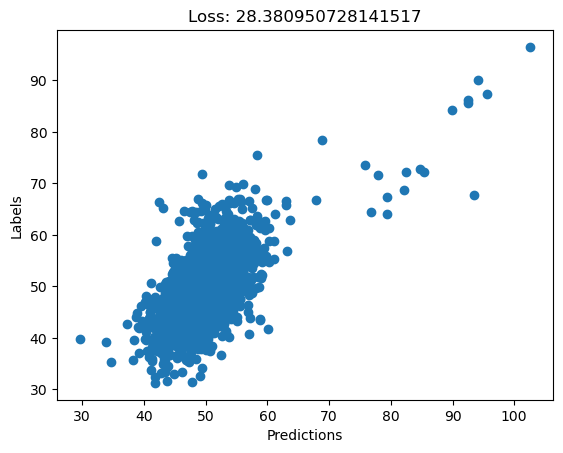

In [5]:
try:
   model, best_epoch_loss = train_model(model, criterion, exp_lr_scheduler, dataloaders=dataloaders, dataset_sizes=dataset_sizes, use_wandb=False,
                    num_epochs=100, prepare_labels = lambda x: x.to("cuda:0"),prepare_inputs= lambda x: x.to("cuda:0") )

except Exception as e:

   telegramBot.send_telegram(f"Training failed with error message: {str(e)}")     

Infering thermostability for sample 0/960...
Diff:  tensor([-1.9236, -1.3941])
Infering thermostability for sample 1/960...
Diff:  tensor([-12.7688,  -5.6263])
Infering thermostability for sample 2/960...
Diff:  tensor([  2.9811, -10.9655])
Infering thermostability for sample 3/960...
Diff:  tensor([5.8250, 7.2242])
Infering thermostability for sample 4/960...
Diff:  tensor([ 2.7399, -6.8216])
Infering thermostability for sample 5/960...
Diff:  tensor([  6.1463, -11.6169])
Infering thermostability for sample 6/960...
Diff:  tensor([0.8882, 0.8063])
Infering thermostability for sample 7/960...
Diff:  tensor([-0.4184,  2.6798])
Infering thermostability for sample 8/960...
Diff:  tensor([-5.5408,  8.8725])
Infering thermostability for sample 9/960...
Diff:  tensor([-1.5293, -2.4571])
Infering thermostability for sample 10/960...
Diff:  tensor([-2.0993, -7.1778])
Infering thermostability for sample 11/960...
Diff:  tensor([ 5.8640, -5.9297])
Infering thermostability for sample 12/960...
Di

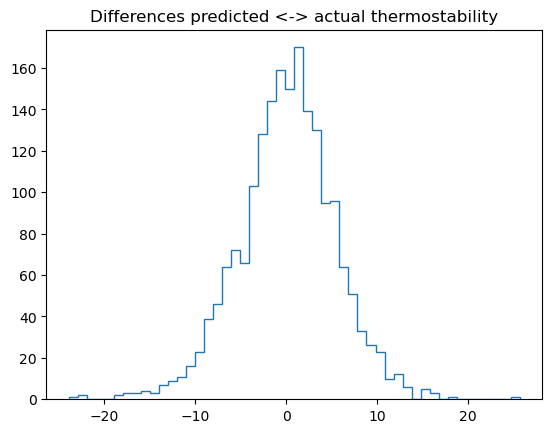

In [11]:
from datetime import datetime

def predictDiffs(set="val"):
    with torch.no_grad():
        n = len(dataloaders[set])
        diffs = torch.tensor([])
        for index, (inputs, labels) in enumerate(dataloaders[set]):
            inputs = inputs.to("cuda:0")
            print(f"Infering thermostability for sample {index}/{n}...")
            labels = labels.to("cuda:0")
            outputs = model(inputs)

            _diffs = outputs.squeeze().sub(labels.squeeze()).cpu()
            diffs = torch.cat((diffs, _diffs))
            print("Diff: ", _diffs)
    return diffs
diffs = predictDiffs()

#diffs = np.array([0, 0.1, 0.2,-0.2, -0.8, 0.1])
plt.title("Differences predicted <-> actual thermostability")
plt.hist(diffs, 50,histtype="step")
resultsDir = "results"
now = datetime.now()
time = now.strftime("%d_%m_%Y_%H:%M:%S")
os.makedirs(resultsDir, exist_ok=True)
histFile = f"results/{time}_diffs.png"
plt.savefig(histFile)
telegramBot.send_photo(histFile, f"Differences predicted <-> actual thermostability at {time}")


In [ ]:
try: 
    modelPath = os.path.join(resultsDir, f"{time}_model.pth")
    torch.save(model, modelPath)
    telegramBot.send_telegram(f"Model saved at {modelPath}")
except Exception as e:
    telegramBot.send_telegram(f"Saving model failed for reason: {str(e)}")